In [ ]:
################################################################
### CREATE combined csv file of f1 data pertinent to project ###
################################################################
import pandas as pd
import numpy as np
## Combine Sprint and Results

# Load csv files (results and sprint_results)
results_df = pd.read_csv("results.csv")            # normal race results
sprint_results_df = pd.read_csv("sprint_results.csv")  # sprint race results

# Print first few data points from each file
results_df.head()
sprint_results_df.head()

# Add a new binary column to indicate if the result is from a sprint race
results_df["isSprint"] = 0
sprint_results_df["isSprint"] = 1

combined_df = pd.concat([results_df, sprint_results_df], ignore_index=True)

# Combine Pitstops.csv
pit_stops = pd.read_csv('pit_stops.csv')
pit_agg = pit_stops.groupby(['raceId', 'driverId']).agg({
    'stop': 'count',
    'milliseconds': ['mean', 'min', 'max'],
    'lap': 'max'
}).reset_index()

pit_agg.columns = ['raceId', 'driverId', 'total_pit_stops', 'avg_pit_ms', 'min_pit_ms', 'max_pit_ms', 'last_pit_lap']

combined_df = combined_df.merge(pit_agg, on=['raceId', 'driverId'], how='left')

# Combine qualifying.csv

qualifying = pd.read_csv('qualifying.csv')

# Drop repeated columns
qualifying = qualifying.drop(columns=['number', 'constructorId', 'qualifyId'])

qualifying = qualifying.rename(columns={
    'position': 'qual_position',
})

combined_df = combined_df.merge(qualifying, on=['raceId', 'driverId'], how='left')

# Rename null columns to NaN
for col in ['q1', 'q2', 'q3']:
    combined_df[col] = combined_df[col].replace('\\N', np.nan)

# Combine constructors.csv to combined_df
constructors = pd.read_csv('constructors.csv')
constructors = constructors.drop(columns='url')

constructors = constructors.rename(columns={
    'name': 'constructor_name'
})

combined_df = combined_df.merge(constructors, on='constructorId', how='left')

# Combine drivers.csv to combined df
drivers = pd.read_csv('drivers.csv')
drivers = drivers.drop(columns=['url', 'number', 'driverRef', 'code'])

drivers = drivers.rename(columns={
    'dob': 'driver_dob'
})

combined_df = combined_df.merge(drivers, on='driverId', how='left')

# Combine race.csv to combined df
races = pd.read_csv('races.csv')
races_subset = races[['raceId', 'year']]

combined_df = combined_df.merge(races_subset, on='raceId', how='left')

# Calculate age
combined_df['driver_dob'] = pd.to_datetime(combined_df['driver_dob'], errors='coerce')
combined_df['race_year'] = pd.to_datetime(combined_df['year'].astype(str) + '-01-01')
combined_df['driver_age'] = (combined_df['race_year'] - combined_df['driver_dob']).dt.days // 365

# Export the final csv
combined_df.to_csv('final_f1data.csv', index=False)

In [ ]:
combined_df.tail()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,constructorRef,constructor_name,nationality_x,forename,surname,driver_dob,nationality_y,year,race_year,driver_age
27114,356,1143,859,215,30,10,16,16,16,0.0,...,rb,RB F1 Team,Italian,Liam,Lawson,2002-02-11,New Zealander,2024,2024-01-01,21
27115,357,1143,852,215,22,16,17,17,17,0.0,...,rb,RB F1 Team,Italian,Yuki,Tsunoda,2000-05-11,Japanese,2024,2024-01-01,23
27116,358,1143,861,3,43,0,18,18,18,0.0,...,williams,Williams,British,Franco,Colapinto,2003-05-27,Argentinian,2024,2024-01-01,20
27117,359,1143,855,15,24,18,19,19,19,0.0,...,sauber,Sauber,Swiss,Guanyu,Zhou,1999-05-30,Chinese,2024,2024-01-01,24
27118,360,1143,815,9,11,0,20,20,20,0.0,...,red_bull,Red Bull,Austrian,Sergio,Pérez,1990-01-26,Mexican,2024,2024-01-01,33


In [ ]:
### Data Exploration
### Examine data types, missing values, descriptive statistics, and unique values in key columns to understand the dataset's characteristics.

# Examine data types
print("Data Types:\n", combined_df.dtypes)

# Check for missing values
missing_values = combined_df.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Descriptive statistics for numerical columns
numerical_cols = combined_df.select_dtypes(include=['number'])
print("\nDescriptive Statistics for Numerical Columns:\n", numerical_cols.describe())

# DataFrame shape and unique values in key columns
print("\nDataFrame Shape:", combined_df.shape)
print("\nUnique Race Names:", combined_df['raceId'].nunique())
print("\nUnique Driver Names:", combined_df['driverId'].nunique())
print("\nUnique Team Names:", combined_df['constructorId'].nunique())

Data Types:
 resultId                     int64
raceId                       int64
driverId                     int64
constructorId                int64
number                      object
grid                         int64
position                    object
positionText                object
positionOrder                int64
points                     float64
laps                         int64
time                        object
milliseconds                object
fastestLap                  object
rank                        object
fastestLapTime              object
fastestLapSpeed             object
statusId                     int64
isSprint                     int64
total_pit_stops            float64
avg_pit_ms                 float64
min_pit_ms                 float64
max_pit_ms                 float64
last_pit_lap               float64
qual_position              float64
q1                          object
q2                          object
q3                          object
constru

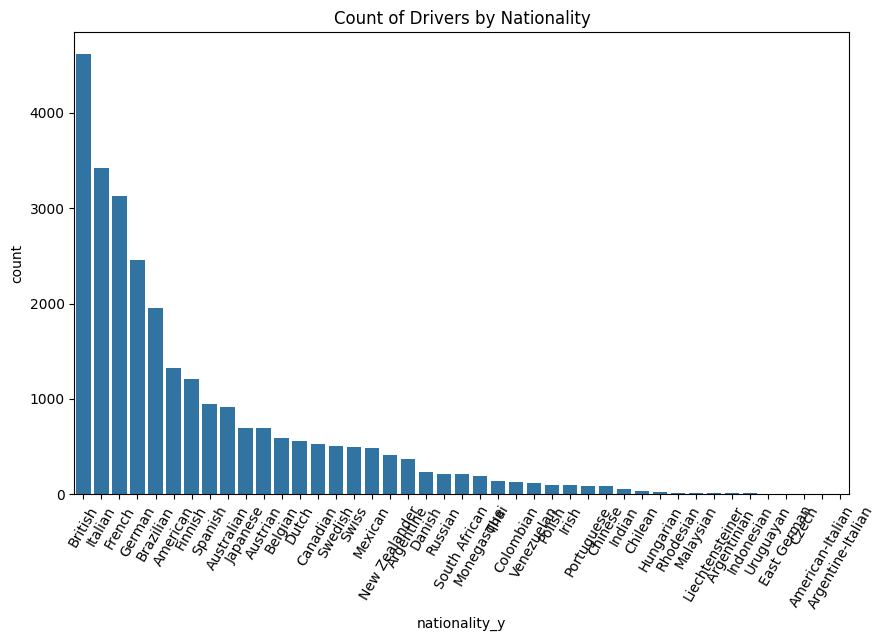

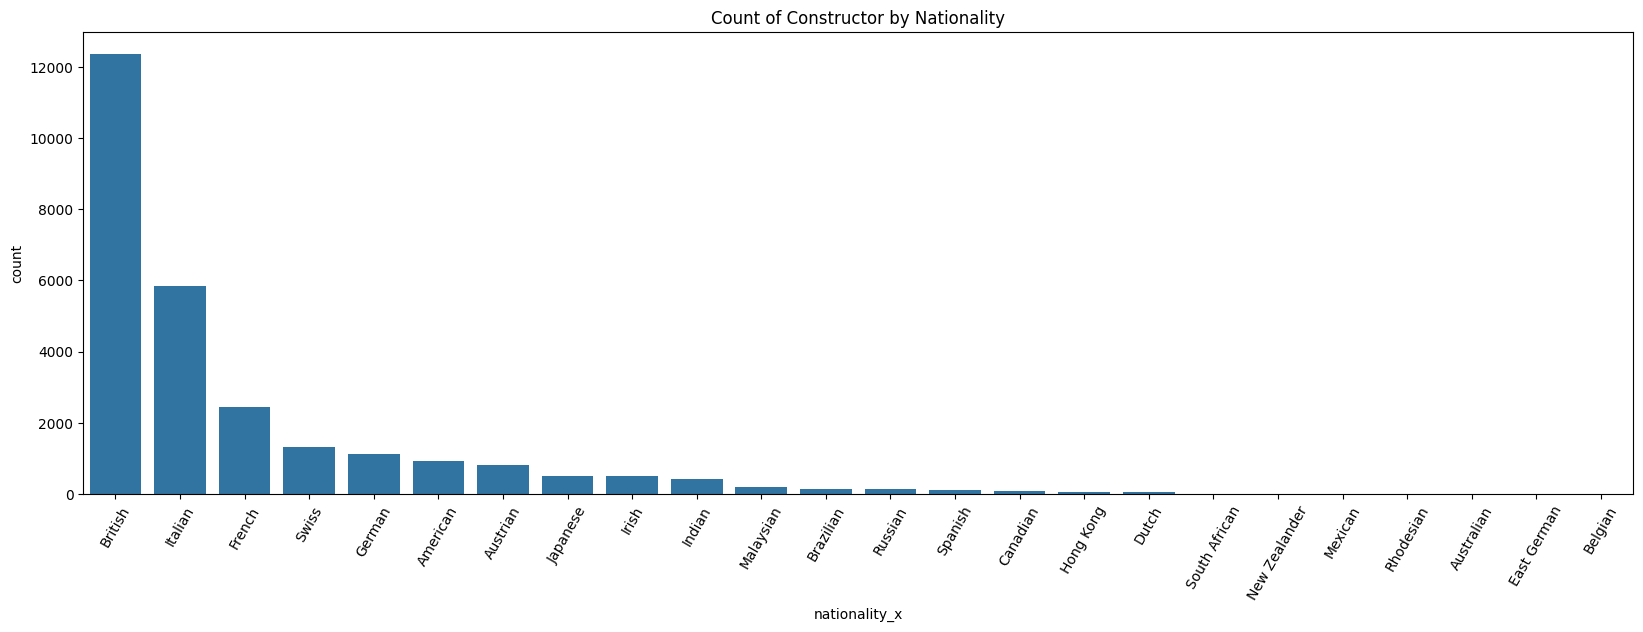

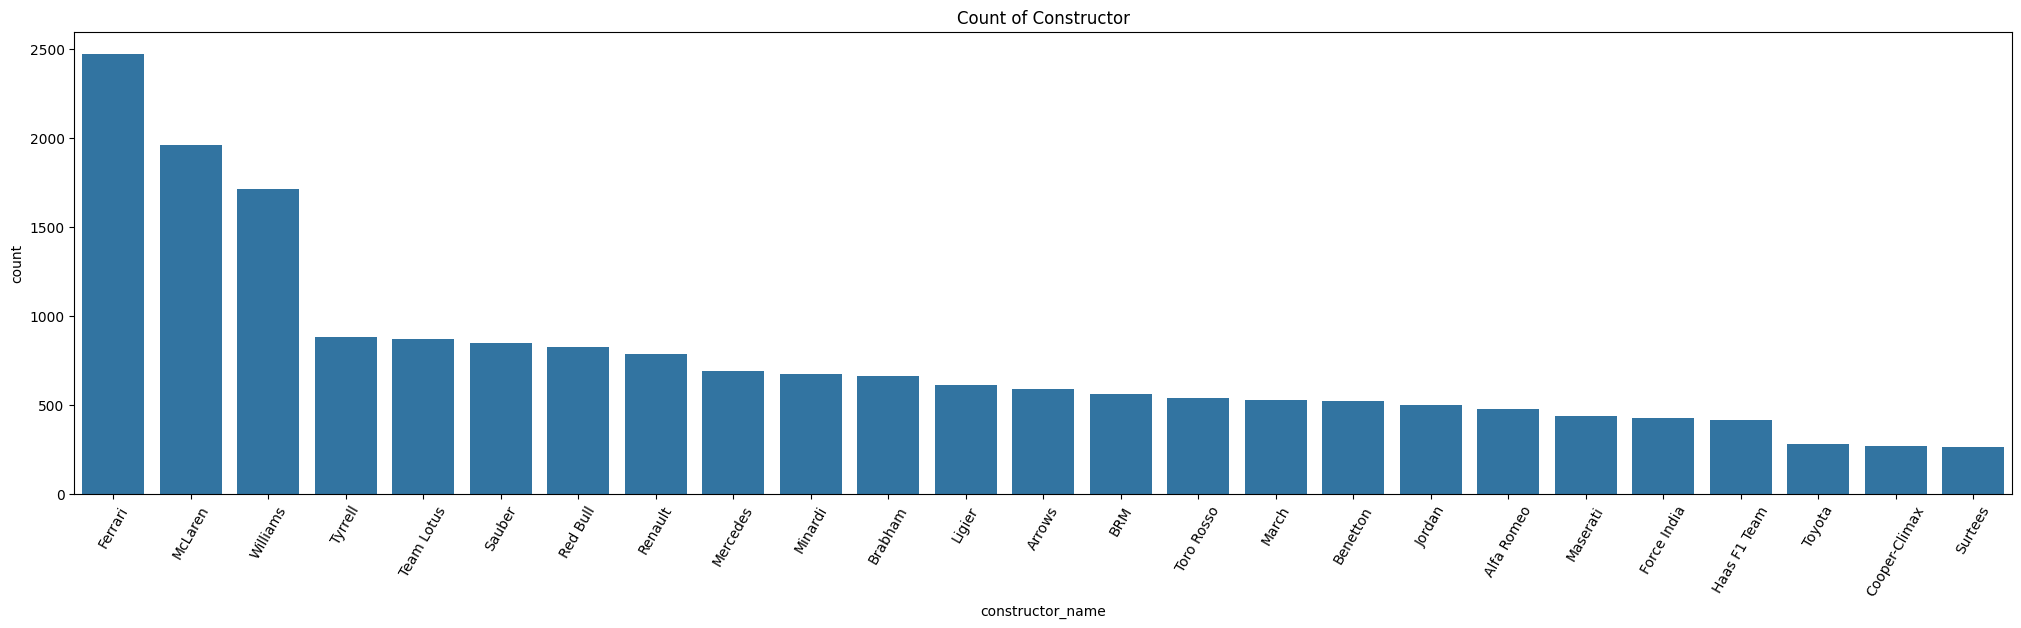

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Distribution of categorical features
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='nationality_y', order=combined_df['nationality_y'].value_counts().index)
plt.title('Count of Drivers by Nationality')
plt.xticks(rotation=60)
plt.show()

plt.figure(figsize=(20, 6))
sns.countplot(data=combined_df, x='nationality_x', order=combined_df['nationality_x'].value_counts().index)
plt.title('Count of Constructor by Nationality')
plt.xticks(rotation=60)
plt.show()

plt.figure(figsize=(25, 6))
sns.countplot(data=combined_df, x='constructor_name', order=combined_df['constructor_name'].value_counts().nlargest(25).index)
plt.title('Count of Constructor')
plt.xticks(rotation=60)
plt.show()

In [ ]:
######################
### Pre-Processing ###
######################

# read in f1 data
f1data = pd.read_csv('final_f1data.csv')

# Convert relevant columns to numeric where possible
# Handle the 'number' column separately as it seems to have mixed types
f1data['number'] = pd.to_numeric(f1data['number'], errors='coerce')
f1data['grid'] = pd.to_numeric(f1data['grid'], errors='coerce')
f1data['position'] = pd.to_numeric(f1data['position'], errors='coerce')
f1data['positionOrder'] = pd.to_numeric(f1data['positionOrder'], errors='coerce')
f1data['points'] = pd.to_numeric(f1data['points'], errors='coerce')
f1data['laps'] = pd.to_numeric(f1data['laps'], errors='coerce')
f1data['milliseconds'] = pd.to_numeric(f1data['milliseconds'], errors='coerce')
f1data['fastestLap'] = pd.to_numeric(f1data['fastestLap'], errors='coerce')
f1data['rank'] = pd.to_numeric(f1data['rank'], errors='coerce')
f1data['avg_pit_ms'] = pd.to_numeric(f1data['avg_pit_ms'], errors='coerce')
f1data['min_pit_ms'] = pd.to_numeric(f1data['min_pit_ms'], errors='coerce')
f1data['max_pit_ms'] = pd.to_numeric(f1data['max_pit_ms'], errors='coerce')
f1data['fastestLapSpeed'] = pd.to_numeric(f1data['fastestLapSpeed'], errors='coerce')

# Create a function to convert fastestLapTime,q1,q2,q3 to secs
def convert_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    try:
        minutes, seconds = time_str.split(':')
        return int(minutes) * 60 + float(seconds)
    except:
        return None
# Apply function to fastestLapTime
f1data['fastestLapTime_seconds'] = f1data['fastestLapTime'].apply(convert_to_seconds)
f1data['q1'] = f1data['q1'].apply(convert_to_seconds)
f1data['q2'] = f1data['q2'].apply(convert_to_seconds)
f1data['q3'] = f1data['q3'].apply(convert_to_seconds)

# Drop irrelevant/redundant columns based on F1 knowledge
# positionText, time, fastestLapTime
f1data = f1data.drop(columns=['positionText', 'time', 'fastestLapTime'])

# Handle missing data
# Drop columns with too many missing values or that aren't useful for regression
f1data_cleaned = f1data.drop(columns=['constructorRef',
                            'forename', 'surname', 'race_year', 'driver_dob',
                              'raceId', 'constructor_name', 'nationality_x', 'nationality_y', 'resultId', 'position',
                                      'positionOrder', 'statusId'])

# Swap milliseconds to seconds
f1data_cleaned['seconds'] = f1data_cleaned['milliseconds'] / 1000
f1data_cleaned['avg_pit_sec'] = f1data_cleaned['avg_pit_ms'] / 1000
f1data_cleaned['min_pit_sec'] = f1data_cleaned['min_pit_ms'] / 1000
f1data_cleaned['max_pit_sec'] = f1data_cleaned['avg_pit_ms'] / 1000
f1data_cleaned = f1data_cleaned.drop(columns=['milliseconds','avg_pit_ms','min_pit_ms','avg_pit_ms'])

f1data_cleaned = f1data_cleaned.dropna()

# Export the final csv
f1data_cleaned.to_csv('cleaned_f1data.csv', index=False)

<ipython-input-5-f9c7e319e355>:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  f1data = pd.read_csv('final_f1data.csv')


In [ ]:
f1data_cleaned.isnull().sum()

,0
driverId,0
constructorId,0
number,0
grid,0
points,0
laps,0
fastestLap,0
rank,0
fastestLapSpeed,0
isSprint,0


In [ ]:
'''######################
### Pre-Processing ###
######################

# read in f1 data
f1data = pd.read_csv('final_f1data.csv')

# Convert relevant columns to numeric where possible
# Handle the 'number' column separately as it seems to have mixed types
f1data['number'] = pd.to_numeric(f1data['number'], errors='coerce')
f1data['grid'] = pd.to_numeric(f1data['grid'], errors='coerce')
f1data['position'] = pd.to_numeric(f1data['position'], errors='coerce')
f1data['positionOrder'] = pd.to_numeric(f1data['positionOrder'], errors='coerce')
f1data['points'] = pd.to_numeric(f1data['points'], errors='coerce')
f1data['laps'] = pd.to_numeric(f1data['laps'], errors='coerce')
f1data['milliseconds'] = pd.to_numeric(f1data['milliseconds'], errors='coerce')
f1data['fastestLap'] = pd.to_numeric(f1data['fastestLap'], errors='coerce')
f1data['rank'] = pd.to_numeric(f1data['rank'], errors='coerce')
f1data['fastestLapSpeed'] = pd.to_numeric(f1data['fastestLapSpeed'], errors='coerce')

# Create a function to convert fastestLapTime to secs
def convert_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    try:
        minutes, seconds = time_str.split(':')
        return int(minutes) * 60 + float(seconds)
    except:
        return None
# Apply function to fastestLapTime
f1data['fastestLapTime_seconds'] = f1data['fastestLapTime'].apply(convert_to_seconds)

# Drop irrelevant columns based on F1 knowledge
# positionText, time, fastestLapTime
f1data = f1data.drop(columns=['positionText', 'time', 'fastestLapTime'])

# Handle missing data
# Drop columns with too many missing values or that aren't useful for regression
f1data_cleaned = f1data.drop(columns=['q1', 'q2', 'q3', 'constructorRef',
                            'forename', 'surname', 'race_year', 'driver_dob',
                              'raceId', 'constructor_name', 'nationality_x', 'nationality_y', 'resultId', 'position', 'positionOrder', 'statusId',
                                     'total_pit_stops', 'avg_pit_ms', 'min_pit_ms', 'max_pit_ms',
                                      'last_pit_lap'])

# Swap milliseconds to seconds
f1data_cleaned['seconds'] = f1data_cleaned['milliseconds'] / 1000
f1data_cleaned = f1data_cleaned.drop(columns=['milliseconds'])

# Drop the null values
f1data_cleaned = f1data_cleaned.dropna()

# Export the final csv
f1data_cleaned.to_csv('cleaned_f1data.csv', index=False)'''

"######################\n### Pre-Processing ###\n######################\n\n# read in f1 data\nf1data = pd.read_csv('final_f1data.csv')\n\n# Convert relevant columns to numeric where possible\n# Handle the 'number' column separately as it seems to have mixed types\nf1data['number'] = pd.to_numeric(f1data['number'], errors='coerce')\nf1data['grid'] = pd.to_numeric(f1data['grid'], errors='coerce')\nf1data['position'] = pd.to_numeric(f1data['position'], errors='coerce')\nf1data['positionOrder'] = pd.to_numeric(f1data['positionOrder'], errors='coerce')\nf1data['points'] = pd.to_numeric(f1data['points'], errors='coerce')\nf1data['laps'] = pd.to_numeric(f1data['laps'], errors='coerce')\nf1data['milliseconds'] = pd.to_numeric(f1data['milliseconds'], errors='coerce')\nf1data['fastestLap'] = pd.to_numeric(f1data['fastestLap'], errors='coerce')\nf1data['rank'] = pd.to_numeric(f1data['rank'], errors='coerce')\nf1data['fastestLapSpeed'] = pd.to_numeric(f1data['fastestLapSpeed'], errors='coerce')\n\

In [ ]:
print(f1data_cleaned.shape)
f1data_cleaned.head()

(2020, 24)


,driverId,constructorId,number,grid,points,laps,fastestLap,rank,fastestLapSpeed,isSprint,...,q1,q2,q3,year,driver_age,fastestLapTime_seconds,seconds,avg_pit_sec,min_pit_sec,max_pit_sec
20776,20,9,1.0,1,25.0,58,44.0,4.0,212.488,0,...,85.296,84.090,83.529,2011,23,89.844,5370.259,23.319500,22.603,23.319500
20777,1,1,3.0,2,18.0,58,41.0,8.0,211.382,0,...,85.384,84.595,84.307,2011,26,90.314,5392.556,23.213000,23.199,23.213000
20778,808,4,10.0,6,15.0,58,55.0,7.0,211.969,0,...,85.543,85.582,85.247,2011,26,90.064,5400.819,25.109000,24.535,25.109000
20779,4,6,5.0,5,12.0,58,49.0,2.0,213.336,0,...,85.707,85.242,84.974,2011,29,89.487,5402.031,24.055000,23.251,24.055000
20780,17,9,2.0,3,10.0,58,50.0,3.0,213.066,0,...,85.900,84.658,84.395,2011,34,89.600,5408.430,24.058667,22.520,24.058667


In [ ]:
f1data_cleaned.dtypes

,0
driverId,int64
constructorId,int64
number,float64
grid,int64
points,float64
laps,int64
fastestLap,float64
rank,float64
fastestLapSpeed,float64
isSprint,int64


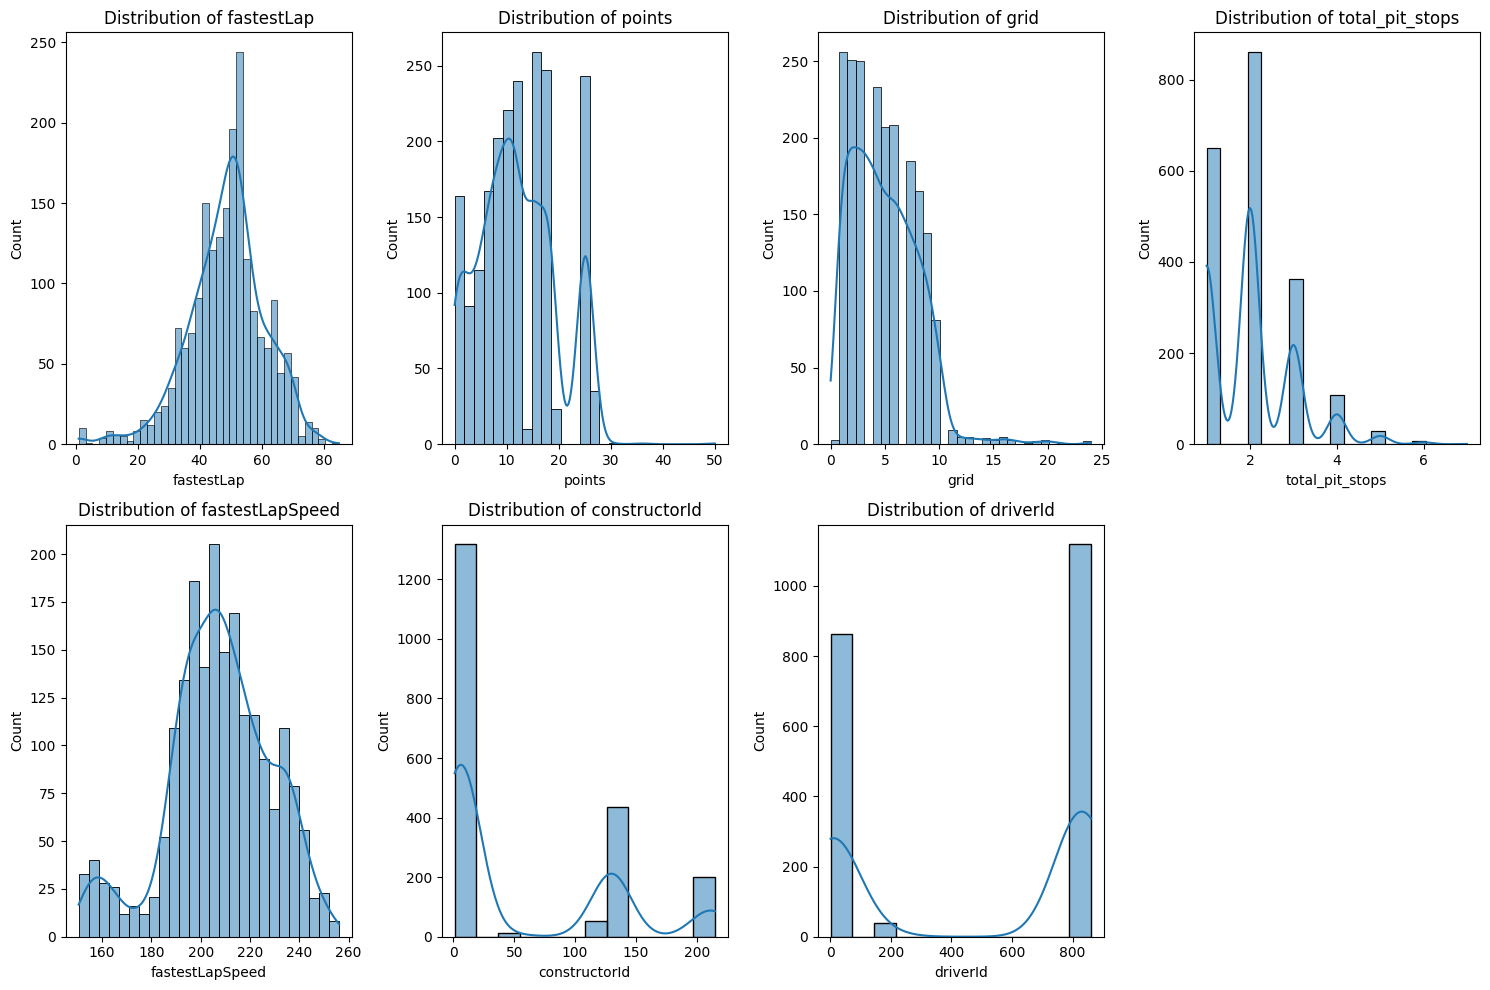


Mean vs. Median for Numerical Columns:
fastestLap: Mean = 48.79, Median = 50.00
points: Mean = 12.10, Median = 12.00
grid: Mean = 4.97, Median = 5.00
total_pit_stops: Mean = 2.03, Median = 2.00
fastestLapSpeed: Mean = 207.49, Median = 207.24
constructorId: Mean = 56.56, Median = 9.00
driverId: Mean = 466.38, Median = 815.00


In [ ]:
 ### Analyze the distribution of key variables, identify potential outliers and missing values, and calculate basic statistics.
import matplotlib.pyplot as plt
import seaborn as sns

# Select key variables for analysis
key_variables = ['fastestLap', 'points', 'grid', 'total_pit_stops', 'fastestLapSpeed', 'constructorId', 'driverId']

# Analyze distribution and identify potential outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(key_variables):
    plt.subplot(2, 4, i + 1)
    sns.histplot(f1data_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Compare mean and median to identify skewness
print("\nMean vs. Median for Numerical Columns:")
numerical_cols = f1data_cleaned[key_variables].select_dtypes(include=['number'])
for col in numerical_cols.columns:
    print(f"{col}: Mean = {f1data_cleaned[col].mean():.2f}, Median = {f1data_cleaned[col].median():.2f}")

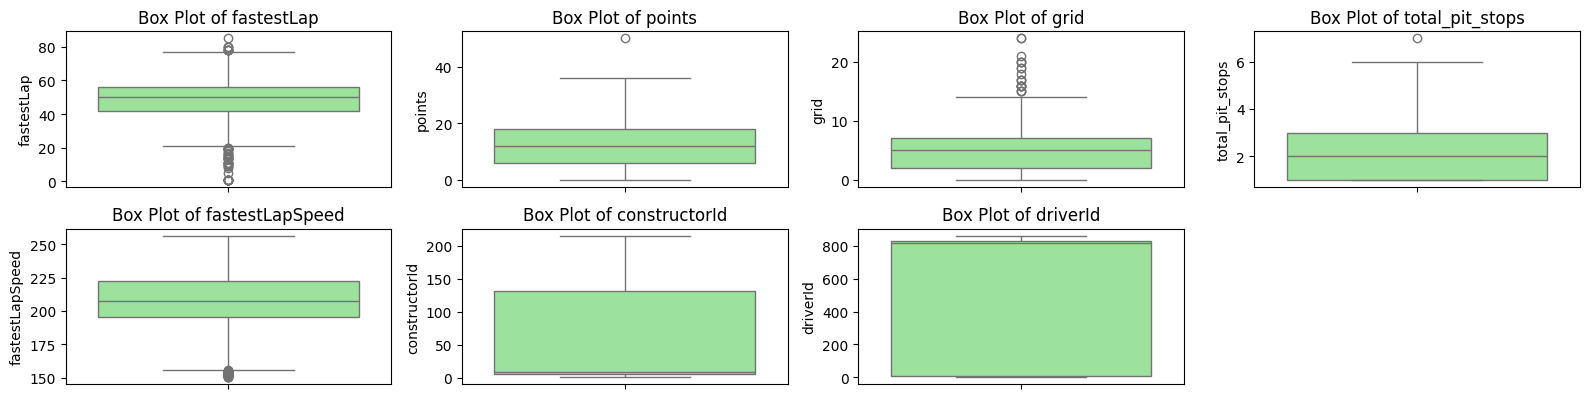

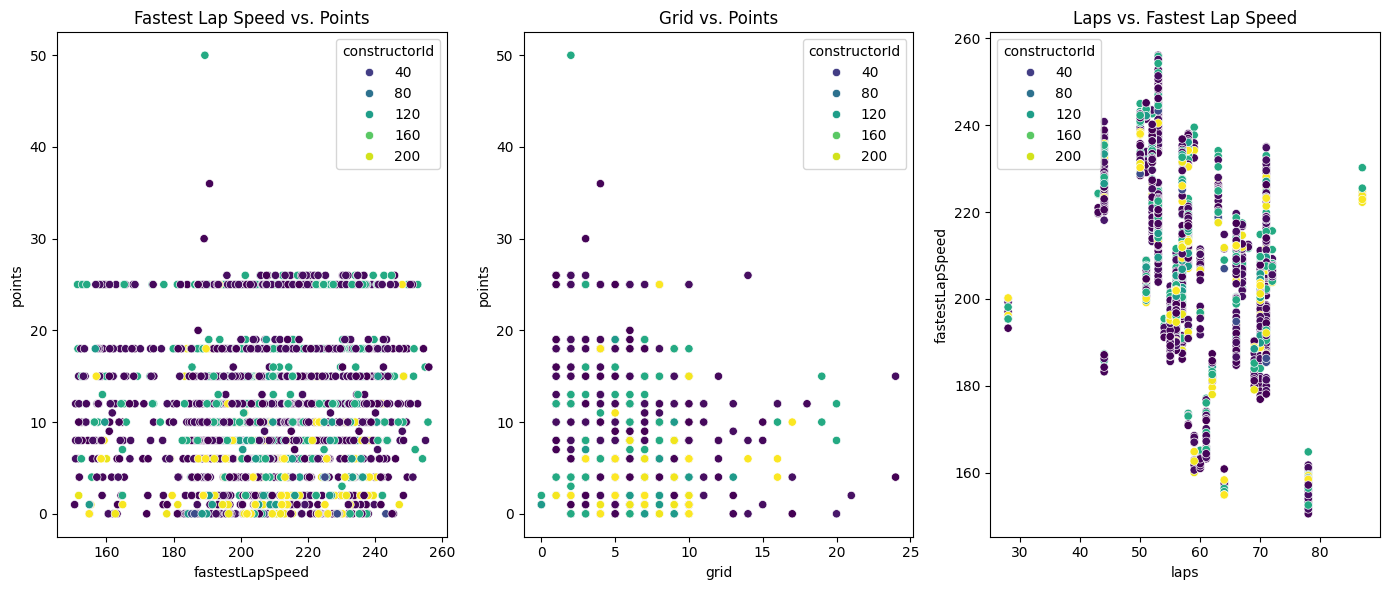

<ipython-input-11-3d5778fe53f8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=driver_points.index, y=driver_points.values, palette='magma')


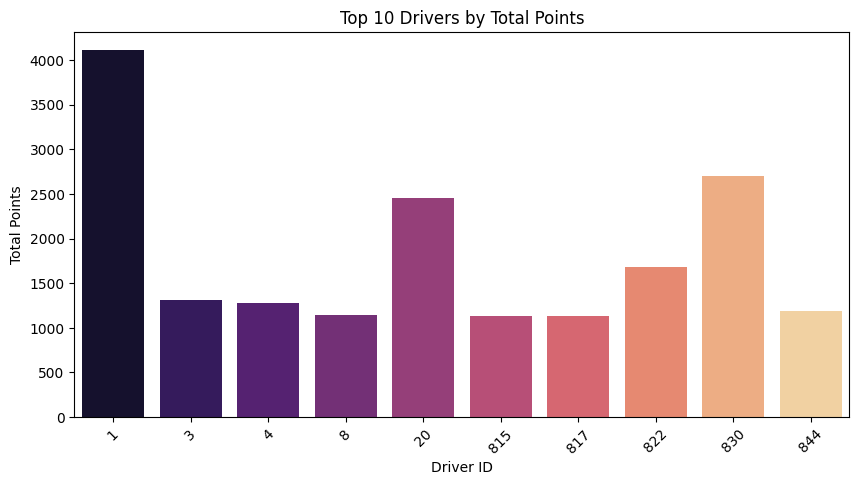

<ipython-input-11-3d5778fe53f8>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=team_points.index, y=team_points.values, palette='viridis')


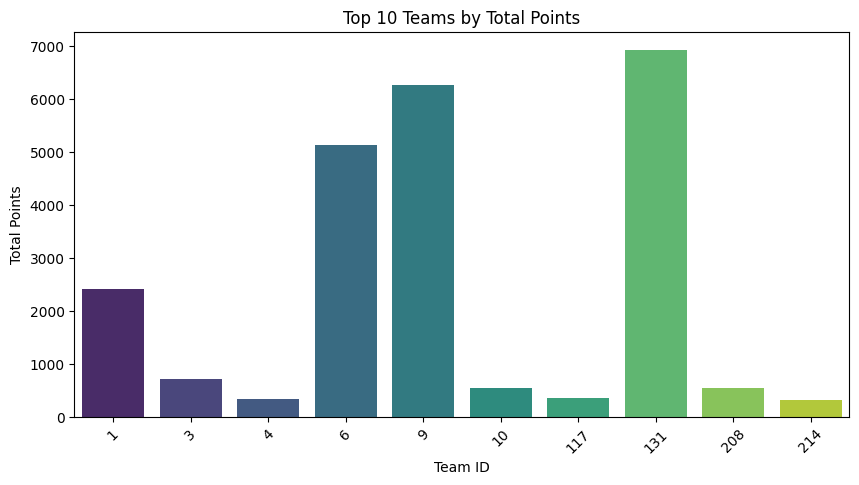

In [ ]:
### Visualize the distributions and relationships between variables in the F1 dataset using histograms, box plots, scatter plots, and bar charts. Handle potential data type issues and missing values in fastestLapSpeed
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Box Plots
numerical_cols = key_variables
plt.figure(figsize=(16, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=f1data_cleaned[col], color='lightgreen')
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# 2. Scatter Plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x='fastestLapSpeed', y='points', data=f1data_cleaned, hue='constructorId', palette='viridis')
plt.title('Fastest Lap Speed vs. Points')

plt.subplot(1, 3, 2)
sns.scatterplot(x='grid', y='points', data=f1data_cleaned, hue='constructorId', palette='viridis')
plt.title('Grid vs. Points')

plt.subplot(1, 3, 3)
# Handle potential issues with fastestLapSpeed
f1data_cleaned_valid_speed = f1data_cleaned.dropna(subset=['fastestLapSpeed'])
sns.scatterplot(x='laps', y='fastestLapSpeed', data=f1data_cleaned_valid_speed, hue='constructorId', palette='viridis')
plt.title('Laps vs. Fastest Lap Speed')

plt.tight_layout()
plt.show()


# 3. Bar Charts for Top Performers
driver_points = f1data_cleaned.groupby('driverId')['points'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=driver_points.index, y=driver_points.values, palette='magma')
plt.title('Top 10 Drivers by Total Points')
plt.xlabel('Driver ID')
plt.ylabel('Total Points')
plt.xticks(rotation=45)
plt.show()

team_points = f1data_cleaned.groupby('constructorId')['points'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=team_points.index, y=team_points.values, palette='viridis')
plt.title('Top 10 Teams by Total Points')
plt.xlabel('Team ID')
plt.ylabel('Total Points')
plt.xticks(rotation=45)
plt.show()

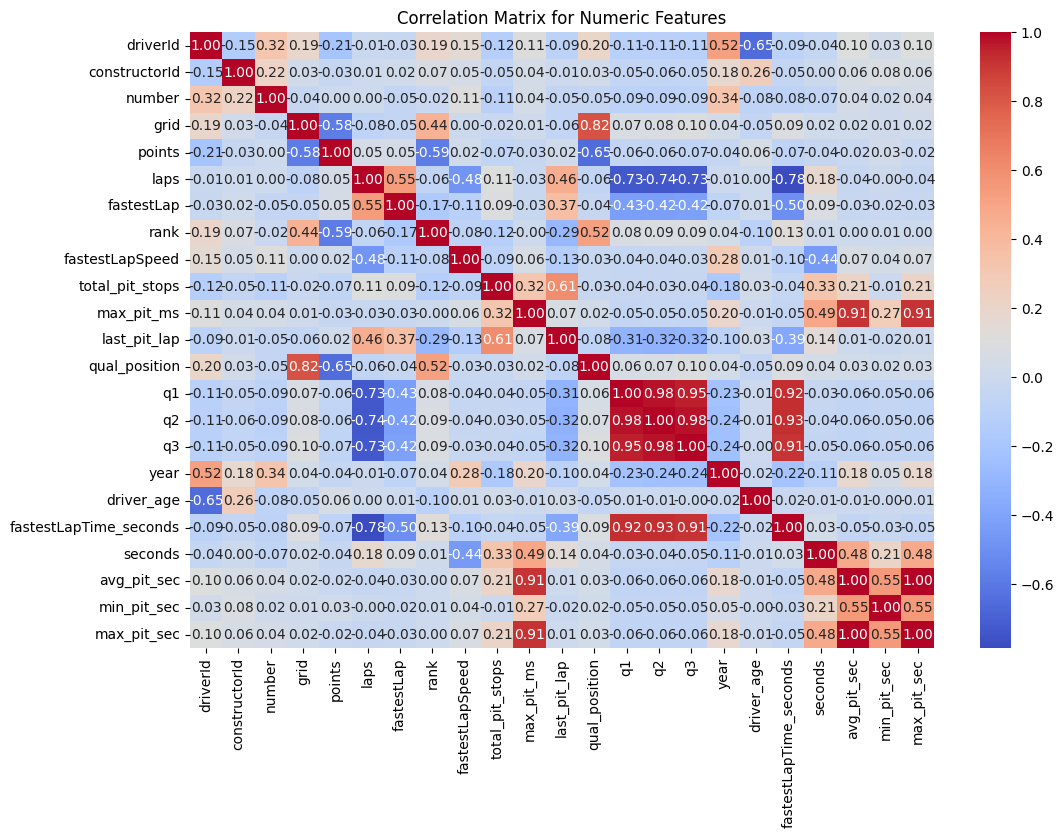


Summary Statistics for Numeric Features:
          driverId  constructorId       number         grid       points  \
count  2020.000000    2020.000000  2020.000000  2020.000000  2020.000000   
mean    466.382673      56.561881    23.226238     4.965842    12.097525   
std     406.193351      72.942110    23.268951     3.074979     7.429570   
min       1.000000       1.000000     1.000000     0.000000     0.000000   
25%       8.000000       6.000000     5.000000     2.000000     6.000000   
50%     815.000000       9.000000    14.000000     5.000000    12.000000   
75%     830.000000     131.000000    33.000000     7.000000    18.000000   
max     861.000000     215.000000    99.000000    24.000000    50.000000   

              laps   fastestLap         rank  fastestLapSpeed  isSprint  ...  \
count  2020.000000  2020.000000  2020.000000      2020.000000    2020.0  ...   
mean     59.547030    48.793564     6.098020       207.488921       0.0  ...   
std       8.910166    12.259876  

In [ ]:
# Check correlation matrix for numeric features
# Need to ensure X contains only numeric types for correlation matrix
# Check data types first

# Select only numeric columns for correlation
numeric = f1data_cleaned.select_dtypes(include=np.number)
numeric = numeric.drop(columns=['isSprint'])

# Check if numeric is empty or has enough columns for correlation
if not numeric.empty and numeric.shape[1] > 1:
    corr_matrix = numeric.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix for Numeric Features')
    plt.show()
else:
    print("Not enough numeric columns to compute and plot correlation matrix.")


# Distribution of categorical features
# Need to re-identify categorical columns from the original pre-processed X *before* get_dummies if needed for countplot
# However, X here is the output of the preprocessor, which is likely a numpy array or processed dataframe.
# Let's assume for the purpose of EDA on categorical features we might need the original or look at the one-hot encoded ones
# For a simple countplot like nationality, we would need the original or access the one-hot encoded versions and sum them.
# Given the structure, the 'nationality' columns are now one-hot encoded. Let's skip the countplot as it's not directly applicable to the processed X without more effort to decode or access original data.

# Summary statistics for numeric columns
summary_stats = f1data_cleaned.describe()
print("\nSummary Statistics for Numeric Features:")
print(summary_stats)

In [ ]:
numeric_final_data = f1data_cleaned.select_dtypes(include=np.number)
correlations = numeric_final_data.corr()['points'].sort_values(ascending=False)
print("\nCorrelation with 'points' (Target Variable):")
print(correlations)


Correlation with 'points' (Target Variable):
points                    1.000000
driver_age                0.063403
laps                      0.051717
fastestLap                0.050851
min_pit_sec               0.029500
last_pit_lap              0.021973
fastestLapSpeed           0.021544
number                    0.004989
max_pit_sec              -0.019528
avg_pit_sec              -0.019528
max_pit_ms               -0.032813
constructorId            -0.034202
seconds                  -0.035175
year                     -0.042533
q1                       -0.059458
q2                       -0.064625
total_pit_stops          -0.072162
q3                       -0.073379
fastestLapTime_seconds   -0.074408
driverId                 -0.208040
grid                     -0.584107
rank                     -0.589025
qual_position            -0.652369
isSprint                       NaN
Name: points, dtype: float64


In [ ]:
X = f1data_cleaned.drop(columns=['points'])
y = f1data_cleaned['points']

In [ ]:
X.shape

(2020, 23)

In [ ]:
y.shape

(2020,)

In [ ]:
X.isnull().sum()

,0
driverId,0
constructorId,0
number,0
grid,0
laps,0
fastestLap,0
rank,0
fastestLapSpeed,0
isSprint,0
total_pit_stops,0


# New section

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, roc_auc_score, r2_score

# Seperate into a train-test split of 70%/30%
# Will use a randstate of 123

# Split data into train-test split
randState = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randState)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Try multiple alpha values for both Lasso and Ridge
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

lasso_results = []
ridge_results = []

for alpha in alphas:
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_preds = lasso.predict(X_test_scaled)
    lasso_r2 = r2_score(y_test, lasso_preds)
    lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
    lasso_results.append((alpha, lasso_r2, lasso_rmse))

    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_preds = ridge.predict(X_test_scaled)
    ridge_r2 = r2_score(y_test, ridge_preds)
    ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
    ridge_results.append((alpha, ridge_r2, ridge_rmse))

L1_bestAlpha, L1_bestr2Score, L1_bestrmse = max(lasso_results, key=lambda x: x[1])
print(f"Best Alpha for L1 Regularization: {L1_bestAlpha} R2 Score: {L1_bestr2Score:.3f}, RMSE: {L1_bestrmse:.3f}")
L2_bestAlpha, L2_bestr2Score, L2_bestrmse = max(ridge_results, key=lambda x: x[1])
print(f"Best Alpha for L2 Regularization: {L2_bestAlpha} R2 Score: {L2_bestr2Score:.3f}, RMSE: {L2_bestrmse:.3f}")



Best Alpha for L1 Regularization: 0.1 R2 Score: 0.556, RMSE: 4.818
Best Alpha for L2 Regularization: 100.0 R2 Score: 0.554, RMSE: 4.828


In [ ]:
# L2 Regularization (Ridge)
ridge = Ridge(alpha= 100.0, random_state=randState)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)

# Evaluation metrics
ridge_r2 = r2_score(y_test, ridge_preds)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))

train_preds_l2 = ridge.predict(X_train_scaled)

trainAcc_l2 = ridge.score(X_train_scaled, y_train)
testAcc_l2 = ridge.score(X_test_scaled, y_test)

print(f"R2 and RMSE: {ridge_r2}, {ridge_rmse}")
print(f"Training Accuracy: {trainAcc_l2}")
print(f"Testing Accuracy: {testAcc_l2}")


R2 and RMSE: 0.5537311838338472, 4.828328667121476
Training Accuracy: 0.5393374187683425
Testing Accuracy: 0.5537311838338472


In [ ]:
# L1 Regularization (Lasso)
lasso = Lasso(alpha=0.1, random_state=randState)
lasso.fit(X_train_scaled, y_train)
lasso_preds = lasso.predict(X_test_scaled)

# Evaluation metrics
lasso_r2 = r2_score(y_test, lasso_preds)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))

train_preds_l1 = lasso.predict(X_train_scaled)

trainAcc_l1 = lasso.score(X_train_scaled, y_train)
testAcc_l1 = lasso.score(X_test_scaled, y_test)

print(f"R2 and RMSE: {lasso_r2}, {lasso_rmse}")
print(f"Training Accuracy: {trainAcc_l2}")
print(f"Testing Accuracy: {testAcc_l2}")



R2 and RMSE: 0.5556972190746714, 4.817681337490508
Training Accuracy: 0.5393374187683425
Testing Accuracy: 0.5537311838338472


In [ ]:
alphaValues = np.linspace(0.001, 100, 10)
trainAcc_l2 = []
testAcc_l2 = []
trainAcc_l1 = []
testAcc_l1 = []


for alpha in alphaValues:

  ridge = Ridge(alpha=alpha)
  ridge.fit(X_train_scaled, y_train)
  p_train_l2 = ridge.predict(X_train_scaled)
  p_test_l2 = ridge.predict(X_test_scaled)

  trainAcc_l2.append(ridge.score(X_train_scaled, y_train))
  testAcc_l2.append(ridge.score(X_test_scaled, y_test))

  lasso = Lasso(alpha=alpha)
  lasso.fit(X_train_scaled, y_train)
  p_train_l1 = lasso.predict(X_train_scaled)
  p_test_l1 = lasso.predict(X_test_scaled)

  trainAcc_l1.append(lasso.score(X_train_scaled,y_train))
  testAcc_l1.append(lasso.score(X_test_scaled, y_test))

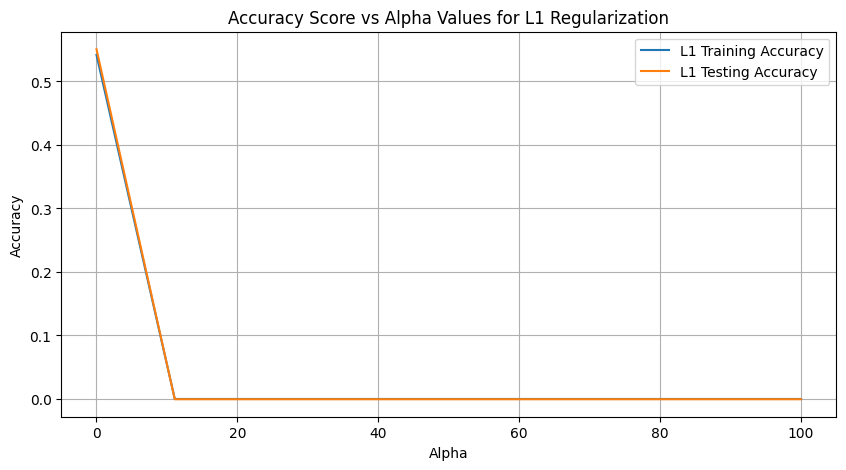

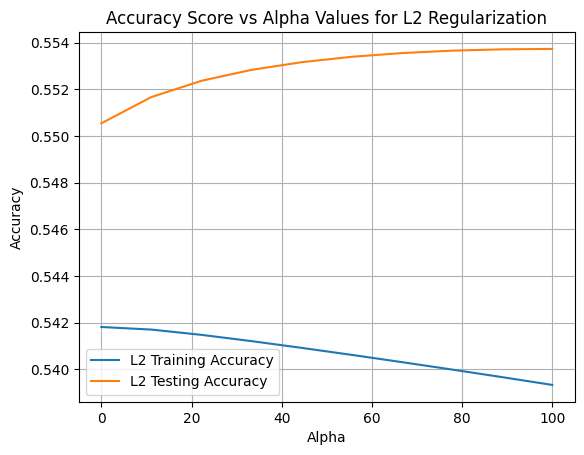

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(alphaValues, trainAcc_l1, label="L1 Training Accuracy")
plt.plot(alphaValues, testAcc_l1, label="L1 Testing Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy Score vs Alpha Values for L1 Regularization")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(alphaValues, trainAcc_l2, label="L2 Training Accuracy")
plt.plot(alphaValues, testAcc_l2, label="L2 Testing Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy Score vs Alpha Values for L2 Regularization")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Fit best models
best_lasso = Lasso(alpha=0.1, max_iter=10000)
best_lasso.fit(X_train_scaled, y_train)

best_ridge = Ridge(alpha=100.0)
best_ridge.fit(X_train_scaled, y_train)

# Extract feature names and coefficients
feature_names = X.columns
lasso_coeffs = best_lasso.coef_
ridge_coeffs = best_ridge.coef_

# Create DataFrame
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Lasso_Coefficient': lasso_coeffs,
    'Ridge_Coefficient': ridge_coeffs
}).sort_values(by='Ridge_Coefficient', key=abs, ascending=False)

coeff_df

,Feature,Lasso_Coefficient,Ridge_Coefficient
6,rank,-2.671264,-2.629244
12,qual_position,-2.586789,-2.345589
3,grid,-0.909122,-1.103787
0,driverId,-0.503575,-0.816568
9,total_pit_stops,-0.613870,-0.705988
11,last_pit_lap,-0.509167,-0.549576
13,q1,-0.062125,-0.394993
4,laps,0.120196,0.334346
17,driver_age,-0.054630,-0.307168
10,max_pit_ms,0.051506,0.266933


In [ ]:
########################
### Gradient Descent ###
########################

# Select target and features
# For this example, let's predict 'points' as the target variable
X = f1data_cleaned.drop(columns=['points'])
y = f1data_cleaned['points']

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Create a training-test set split
# We will use a 70/30 % split
randState = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randState)

In [ ]:
# Initialize the base Gradient Boosting Model
gb = GradientBoostingRegressor(random_state=randState)

# Create a hyperparameter grid to test different params
grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 3]
}

In [ ]:
# Create a Grid Search of Gradient Boosting to determine the optimal parameters
# Will run cross 5-fold cross validation with a neg mean squared error to score the models
grid_search = GridSearchCV(estimator=gb, param_grid=grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)